<a href="https://colab.research.google.com/github/Creator-Aaron/CISC484PAP/blob/main/Copy_of_Dataframes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the og_df

In [ ]:
from google.colab import files

# Upload the Kaggle API credentials file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d roshan81/ageutk

 81% 95.0M/117M [00:00<00:00, 122MB/s]
100% 117M/117M [00:00<00:00, 128MB/s] 


In [ ]:
!unzip -q ageutk.zip -d ML_Project


In [98]:
import pandas as pd
import matplotlib.pyplot as plt
##Import the necessary libraries
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score

In [99]:
# Check if GPU is available and move model and data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [100]:
data = pd.read_csv("/content/drive/MyDrive/ML Proj/ageutk_full.csv")

def df_range(df, min_val, max_val):
    return df[(min_val <= df.age) & (df.age <= max_val)]


og_df= df_range(data,0, 70)
print(og_df)


                                       files  age  gender
0      26_0_2_20170104023102422.jpg.chip.jpg   26       0
1      22_1_1_20170112233644761.jpg.chip.jpg   22       1
2      21_1_3_20170105003215901.jpg.chip.jpg   21       1
3      28_0_0_20170117180555824.jpg.chip.jpg   28       0
4      17_1_4_20170103222931966.jpg.chip.jpg   17       1
...                                      ...  ...     ...
23163  41_0_0_20170109012220690.jpg.chip.jpg   41       0
23164  42_0_0_20170117185738076.jpg.chip.jpg   42       0
23165   2_0_2_20161219221701671.jpg.chip.jpg    2       0
23166  65_1_0_20170110182002744.jpg.chip.jpg   65       1
23167  66_0_1_20170117195116702.jpg.chip.jpg   66       0

[22483 rows x 3 columns]


# Here I got a visualized distribution of ages in the original dataset

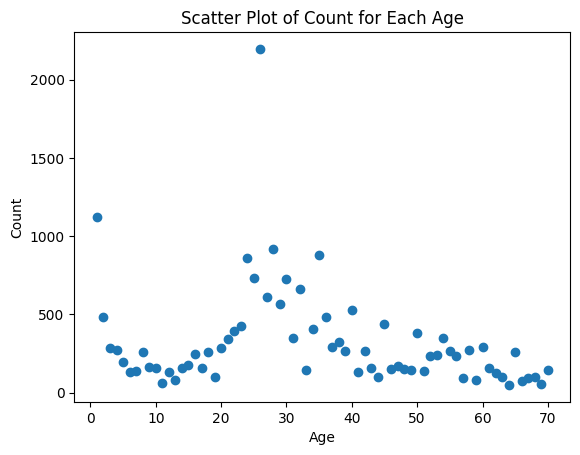

In [101]:
#Calculate the count of each instance and create scatter plt:
count_df = og_df.groupby('age').size().reset_index(name='Count')
#Add labels
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Scatter Plot of Count for Each Age')
plt.scatter(count_df['age'], count_df['Count'])
plt.show()

#it appears that the distribution can be improved see plot belo

# Balancing dataset to have an even amount of entries for each age. 10 entries each

In [102]:
# Get the minimum count
min_count = count_df['Count'].min() -40

# Print the result
print(f"The minimum count is: {min_count}")


The minimum count is: 10


# change this to potentially have more data

In [103]:
import pandas as pd

def extract_instances(df, test_size=0.1):
    result_df = pd.DataFrame(columns=df.columns)
    test_df = pd.DataFrame(columns=df.columns)

    # Iterate over unique ages
    for age in df['age'].unique():
        # Filter by age
        age_df = df[df['age'] == age]

        # Extract 5 male and 5 female instances randomly without replacement
        male_instances = age_df[age_df['gender'] == 1].sample(10, replace=False)
        female_instances = age_df[age_df['gender'] == 0].sample(10, replace=False)

        # Split instances into training and test sets
        male_train, male_test = train_test_split(male_instances, test_size=test_size)
        female_train, female_test = train_test_split(female_instances, test_size=test_size)

        # Concatenate the training results to the final DataFrame
        result_df = pd.concat([result_df, male_train, female_train])

        # Concatenate the test results to the test DataFrame
        test_df = pd.concat([test_df, male_test, female_test])

    return result_df, test_df

# Call the function
train_df, test_df = extract_instances(og_df)

# Print the results
print("Training Set:")
print(train_df)

print("\nTest Set:")
print(test_df)


Training Set:
                                       files age gender
6442   26_1_1_20170112212028557.jpg.chip.jpg  26      1
17899  26_1_3_20170119155121850.jpg.chip.jpg  26      1
15820  26_1_2_20170116184510768.jpg.chip.jpg  26      1
15101  26_1_2_20170116184052988.jpg.chip.jpg  26      1
303    26_1_1_20170112210535941.jpg.chip.jpg  26      1
...                                      ...  ..    ...
19168  68_0_0_20170117172924008.jpg.chip.jpg  68      0
20079  68_0_0_20170117172938504.jpg.chip.jpg  68      0
23063  68_0_0_20170104213632941.jpg.chip.jpg  68      0
13489  68_0_0_20170105173736735.jpg.chip.jpg  68      0
6557   68_0_0_20170117172835921.jpg.chip.jpg  68      0

[1260 rows x 3 columns]

Test Set:
                                       files age gender
17656  26_1_1_20170112213016277.jpg.chip.jpg  26      1
8997   26_0_0_20170113210319560.jpg.chip.jpg  26      0
13228  22_1_2_20170116162023656.jpg.chip.jpg  22      1
8508   22_0_2_20170116172148714.jpg.chip.jpg  22      

Get train data

In [104]:
# Specify the path to the folder containing images in your Google Drive
folder_path = '/content/ML_Project/UTKFace/UTKFace/UTKFace'
# Initialize lists to store data
age_column = []
gender_column = []
image_tensors = []

# Loop through each row in the DataFrame
for index, row in train_df.iterrows():
    # Construct the full path to the image
    image_path = os.path.join(folder_path, row['files'])

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to a NumPy array (tensor)
    image_tensor = np.array(image)

    # Convert the RGB image tensor to weighted grayscale
    gray_image_tensor = np.dot(image_tensor[..., :3], [0.299, 0.587, 0.114])

    # Append the age, gender, and image_tensor to their respective lists
    age_column.append(row['age'])
    gender_column.append(row['gender'])
    image_tensors.append(gray_image_tensor)

# Convert the lists to NumPy arrays
train_label = np.array(age_column)
train_gender = np.array(gender_column)
train_image_tensors = np.array(image_tensors)
train_image_tensors = train_image_tensors.reshape((1260, -1))

# Reshape arr1 to have the same number of rows as arr2 and one column
train_gender_reshaped = train_gender.reshape((-1, 1))

# Stack the two arrays horizontally
train_image_tensors = np.hstack((train_image_tensors, train_gender_reshaped))


# Display the shapes of the arrays
print("label Array Shape:", train_label.shape)

print("Image Tensors Array Shape:", train_image_tensors.shape)



label Array Shape: (1260,)
Image Tensors Array Shape: (1260, 40001)


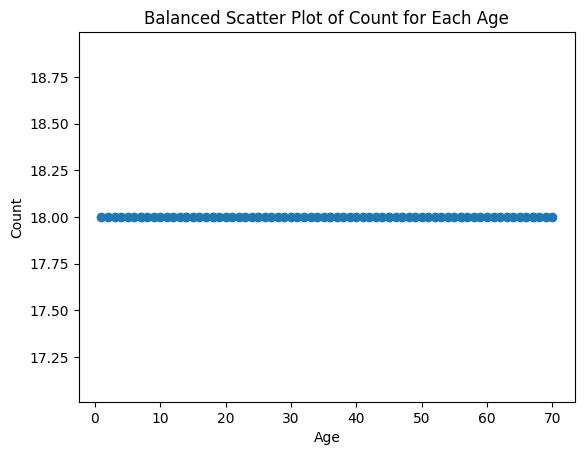

In [105]:
# Calculate the count of each instance in the balanced dataset
balanced_train_df = train_df.groupby('age').size().reset_index(name='Count')
plt.scatter(balanced_train_df['age'], balanced_train_df['Count'])

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Balanced Scatter Plot of Count for Each Age')

# Display the plot
plt.show()


Getting test data

In [106]:
# Specify the path to the folder containing images in your Google Drive
folder_path = '/content/ML_Project/UTKFace/UTKFace/UTKFace'
# Initialize lists to store data
age_column = []
gender_column = []
image_tensors = []

# Loop through each row in the DataFrame
for index, row in test_df.iterrows():
    # Construct the full path to the image
    image_path = os.path.join(folder_path, row['files'])

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to a NumPy array (tensor)
    image_tensor = np.array(image)

    # Convert the RGB image tensor to weighted grayscale
    gray_image_tensor = np.dot(image_tensor[..., :3], [0.299, 0.587, 0.114])

    # Append the age, gender, and image_tensor to their respective lists
    age_column.append(row['age'])
    gender_column.append(row['gender'])
    image_tensors.append(gray_image_tensor)

# Convert the lists to NumPy arrays
test_label = np.array(age_column)
test_gender = np.array(gender_column)
test_image_tensors = np.array(image_tensors)
test_image_tensors = test_image_tensors.reshape((140, -1))

# Reshape arr1 to have the same number of rows as arr2 and one column
test_gender_reshaped = test_gender.reshape((-1, 1))

# Stack the two arrays horizontally
test_image_tensors = np.hstack((test_image_tensors, test_gender_reshaped))
# Display the shapes of the arrays
print("label Array Shape:", test_label.shape)

print("Image Tensors Array Shape:", test_image_tensors.shape)


label Array Shape: (140,)
Image Tensors Array Shape: (140, 40001)


# get test_Df of ages 0-35

In [108]:
# Create a modified DataFrame with instances where 'Age' is less than 35
u35_df = test_df[test_df['age'] < 35]

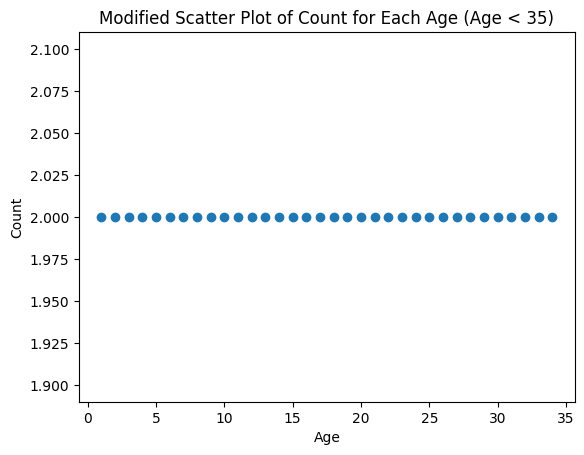

In [109]:
# Plot the scatter plot for the modified dataset
modified_count_u35_df = u35_df.groupby('age').size().reset_index(name='Count')
plt.scatter(modified_count_u35_df['age'], modified_count_u35_df['Count'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Modified Scatter Plot of Count for Each Age (Age < 35)')
plt.show()

In [110]:
# Specify the path to the folder containing images in your Google Drive
folder_path = '/content/ML_Project/UTKFace/UTKFace/UTKFace'
# Initialize lists to store data
age_column = []
gender_column = []
image_tensors = []

# Loop through each row in the DataFrame
for index, row in u35_df.iterrows():
    # Construct the full path to the image
    image_path = os.path.join(folder_path, row['files'])

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to a NumPy array (tensor)
    image_tensor = np.array(image)

    # Convert the RGB image tensor to weighted grayscale
    gray_image_tensor = np.dot(image_tensor[..., :3], [0.299, 0.587, 0.114])

    # Append the age, gender, and image_tensor to their respective lists
    age_column.append(row['age'])
    gender_column.append(row['gender'])
    image_tensors.append(gray_image_tensor)

# Convert the lists to NumPy arrays
u35_label = np.array(age_column)
u35_gender = np.array(gender_column)
u35_image_tensors = np.array(image_tensors)
u35_image_tensors = u35_image_tensors.reshape(68, -1)

# Assuming arr1 is the array of length 72, and arr2 is the array of shape (72, 40000)
arr1 = np.random.rand(72)  # Replace this with your actual array
arr2 = np.random.rand(72, 40000)  # Replace this with your actual array

# Reshape arr1 to have the same number of rows as arr2 and one column
u35_gender_reshaped = u35_gender.reshape((-1, 1))

# Stack the two arrays horizontally
u35_image_tensors = np.hstack((u35_image_tensors, u35_gender_reshaped))
# Display the shapes of the arrays
print("label Array Shape:", u35_label.shape)
print("Image Tensors Array Shape:", u35_image_tensors.shape)


label Array Shape: (68,)
Image Tensors Array Shape: (68, 40001)


# get df of ages 35-70

In [111]:
# Create a modified DataFrame with instances where 'Age' is greater than or equal to 35
above_35_df = test_df[test_df['age'] >= 35]


In [112]:
# Print the modified DataFrame of ages above 35
print("Modified DataFrame:")
print(above_35_df)

Modified DataFrame:
                                       files age gender
21667  44_1_0_20170104210419052.jpg.chip.jpg  44      1
3682   44_0_0_20170113210127508.jpg.chip.jpg  44      0
13496  35_1_0_20170103183453835.jpg.chip.jpg  35      1
6231   35_0_0_20170117175811427.jpg.chip.jpg  35      0
3710   36_1_1_20170117133947127.jpg.chip.jpg  36      1
...                                      ...  ..    ...
15902  48_0_0_20170117140153107.jpg.chip.jpg  48      0
16616  39_1_0_20170104210047180.jpg.chip.jpg  39      1
16052  39_0_0_20170104201949978.jpg.chip.jpg  39      0
17097  68_1_0_20170103184201412.jpg.chip.jpg  68      1
1257   68_0_0_20170111204848471.jpg.chip.jpg  68      0

[72 rows x 3 columns]


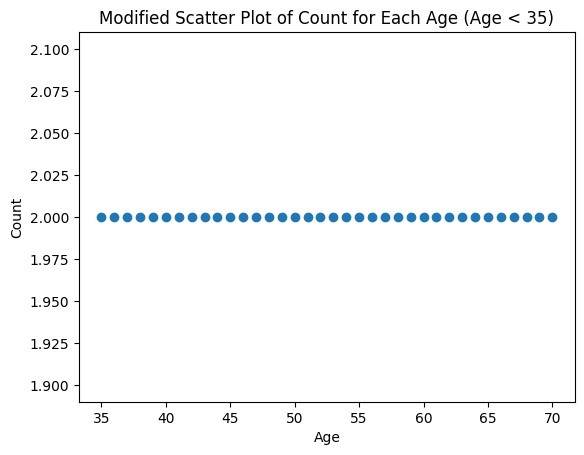

In [113]:

# Plot the scatter plot for the modified dataset for ages above 35
modified_count_above35_df = above_35_df.groupby('age').size().reset_index(name='Count')
plt.scatter(modified_count_above35_df['age'], modified_count_above35_df['Count'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Modified Scatter Plot of Count for Each Age (Age < 35)')
plt.show()

In [114]:




# Specify the path to the folder containing images in your Google Drive
folder_path = '/content/ML_Project/UTKFace/UTKFace/UTKFace'
# Initialize lists to store data
age_column = []
gender_column = []
image_tensors = []

# Loop through each row in the DataFrame
for index, row in above_35_df.iterrows():
    # Construct the full path to the image
    image_path = os.path.join(folder_path, row['files'])

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to a NumPy array (tensor)
    image_tensor = np.array(image)

    # Convert the RGB image tensor to weighted grayscale
    gray_image_tensor = np.dot(image_tensor[..., :3], [0.299, 0.587, 0.114])

    # Append the age, gender, and image_tensor to their respective lists
    age_column.append(row['age'])
    gender_column.append(row['gender'])
    image_tensors.append(gray_image_tensor)

# Convert the lists to NumPy arrays
above_35_label = np.array(age_column)
above_35_gender = np.array(gender_column)
above_35_image_tensors = np.array(image_tensors)
above_35_image_tensors = above_35_image_tensors.reshape(72, -1)
# Assuming arr1 is the array of length 72, and arr2 is the array of shape (72, 40000)
arr1 = np.random.rand(72)  # Replace this with your actual array
arr2 = np.random.rand(72, 40000)  # Replace this with your actual array

# Reshape arr1 to have the same number of rows as arr2 and one column
above_35_gender_reshaped = above_35_gender.reshape((-1, 1))

# Stack the two arrays horizontally
above_35_image_tensors = np.hstack((above_35_image_tensors, above_35_gender_reshaped))
# Display the shapes of the arrays
print("label Array Shape:", above_35_label.shape)
print("Image Tensors Array Shape:", above_35_image_tensors.shape)


label Array Shape: (72,)
Image Tensors Array Shape: (72, 40001)


Getting balance_df test set

In [115]:
# Convert NumPy arrays to PyTorch tensors
train_label = torch.tensor(train_label, dtype=torch.long)
train_image_tensors = torch.tensor(train_image_tensors, dtype=torch.float)

In [125]:
class ThreeLinearLayerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ThreeLinearLayerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(2000, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Set the input, hidden, and output sizes based on your data
input_size = 40001
hidden_size = 256
output_size = 71

In [130]:
# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_tensors, labels):
        self.image_tensors = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.image_tensors[idx], self.labels[idx]

# Create a DataLoader for your dataset
dataset = CustomDataset(train_image_tensors, train_label)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [131]:


# Instantiate the model and move it to GPU
model = ThreeLinearLayerModel(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [132]:
# Training loop
num_epochs = 750
model.train()
for epoch in range(num_epochs):
    for batch_images, batch_labels in dataloader:
      # Move batch data to GPU
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        # Forward pass
        outputs = model(batch_images)

        # Compute the loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/750], Loss: 4.236327171325684
Epoch [2/750], Loss: 4.266475677490234
Epoch [3/750], Loss: 4.240444660186768
Epoch [4/750], Loss: 4.428926467895508
Epoch [5/750], Loss: 4.507040023803711
Epoch [6/750], Loss: 4.421314239501953
Epoch [7/750], Loss: 4.243272304534912
Epoch [8/750], Loss: 4.475138187408447
Epoch [9/750], Loss: 4.29671573638916
Epoch [10/750], Loss: 4.448749542236328
Epoch [11/750], Loss: 4.319596290588379
Epoch [12/750], Loss: 4.249947547912598
Epoch [13/750], Loss: 4.152487754821777
Epoch [14/750], Loss: 4.413296699523926
Epoch [15/750], Loss: 4.319032669067383
Epoch [16/750], Loss: 4.3024115562438965
Epoch [17/750], Loss: 4.3788065910339355
Epoch [18/750], Loss: 4.328176021575928
Epoch [19/750], Loss: 4.2540693283081055
Epoch [20/750], Loss: 4.43540620803833
Epoch [21/750], Loss: 4.368250370025635
Epoch [22/750], Loss: 4.425031661987305
Epoch [23/750], Loss: 4.293853282928467
Epoch [24/750], Loss: 4.535019874572754
Epoch [25/750], Loss: 4.457972049713135
Epoch [2

In [133]:
# Save the trained model if needed
torch.save(model.state_dict(), 'three_linear_layer_model.pth')

Test results for age range 0-70

In [134]:
# Set the model to evaluation mode
model.eval()

# Assuming test_image_tensors is your test data and test_labels is the corresponding ground truth
# Convert NumPy arrays to PyTorch tensors
test_labels = torch.tensor(test_label, dtype=torch.long)
test_image_tensors = torch.tensor(test_image_tensors, dtype=torch.float)
test_labels = test_labels.to(device)
test_image_tensors = test_image_tensors.to(device)
# Make predictions
with torch.no_grad():
    outputs = model(test_image_tensors)

# Get predicted labels
_, predicted_labels = torch.max(outputs, 1)

# Compute accuracy within a tolerance of 5
accuracy = torch.sum(torch.abs(predicted_labels - test_labels) <= 5).item() / len(test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute precision (optional, if you have multiclass classification)
precision = precision_score(test_labels.cpu(), predicted_labels.cpu(), average='weighted')
print(f'Precision: {precision * 100:.2f}%')


Accuracy: 15.71%
Precision: 0.02%


<ipython-input-134-11fc94b2e18f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_image_tensors = torch.tensor(test_image_tensors, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Results for age range 0-35

In [135]:
# Assuming test_image_tensors is your test data and test_labels is the corresponding ground truth
# Convert NumPy arrays to PyTorch tensors
u35_labels = torch.tensor(u35_label, dtype=torch.long)
u35_image_tensors = torch.tensor(u35_image_tensors, dtype=torch.float)
u35_labels = u35_labels.to(device)
u35_image_tensors = u35_image_tensors.to(device)
# Make predictions
with torch.no_grad():
    u35_outputs = model(u35_image_tensors)

# Get predicted labels
_, u_35_predicted_labels = torch.max(u35_outputs, 1)

# Compute accuracy within a tolerance of 5
accuracy = torch.sum(torch.abs(u_35_predicted_labels - u35_labels) <= 5).item() / len(u35_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')
# Compute precision (optional, if you have multiclass classification)
precision = precision_score(u35_labels.cpu(), u_35_predicted_labels.cpu(), average='weighted')
print(f'Precision: {precision * 100:.2f}%')

Accuracy: 32.35%
Precision: 0.09%


<ipython-input-135-38f96c500a40>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u35_image_tensors = torch.tensor(u35_image_tensors, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results for age range 35-70

In [137]:
# Assuming test_image_tensors is your test data and test_labels is the corresponding ground truth
# Convert NumPy arrays to PyTorch tensors
above_35_labels = torch.tensor(above_35_label, dtype=torch.long)
above_35_image_tensors = torch.tensor(above_35_image_tensors, dtype=torch.float)
above_35_labels = above_35_labels.to(device)
above_35_image_tensors = above_35_image_tensors.to(device)
# Make predictions
with torch.no_grad():
    above_35_outputs = model(above_35_image_tensors)

# Get predicted labels
_, above_35_predicted_labels = torch.max(above_35_outputs, 1)
# Compute accuracy within a tolerance of 5
accuracy = torch.sum(torch.abs(above_35_predicted_labels - above_35_labels) <= 5).item() / len(above_35_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')
# Compute precision (optional, if you have multiclass classification)
precision = precision_score(above_35_labels.cpu(), above_35_predicted_labels.cpu(), average='weighted')
print(f'Precision: {precision * 100:.2f}%')

Accuracy: 0.00%
Precision: 0.00%


<ipython-input-137-aef310533985>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  above_35_image_tensors = torch.tensor(above_35_image_tensors, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
